# Goals

* Use map-reduce-subgraph framework with SRA tools agent

In [1]:
# import 
import os
import re
import time
from pprint import pprint 
from datetime import datetime, timedelta
from typing import Annotated, List, Dict, Tuple, Optional, Union, Any
import xml.etree.ElementTree as ET
from pydantic import BaseModel, Field
from langchain_core.tools import tool
from Bio import Entrez

# Tools

In [2]:
# set up Entrez
Entrez.email = "nick.youngblut@arcinstitute.org"

In [3]:
@tool 
def esearch(
    esearch_query: Annotated[str, "Entrez query string."],
    database: Annotated[str, "Database name ('sra' or 'gds')"]="sra",
    #organism: Annotated[str, "Organism name ('human' or 'mouse')"]="human",
    )-> Annotated[List[str], "IDs of database records"]:
    """
    Run an Entrez search query and return the IDs of the results.
    """
    # date range
    start_date = datetime.now() - timedelta(days=7)
    end_date = datetime.now()
    date_range = f"{start_date.strftime('%Y/%m/%d')}:{end_date.strftime('%Y/%m/%d')}[PDAT]"
    esearch_query += f" AND {date_range}"

    max_ids = 2  # DEBUG

    # query
    ids = []
    retstart = 0
    retmax = 50
    while True:
        try:
            search_handle = Entrez.esearch(
                db=database, 
                term=esearch_query, 
                retstart=retstart, 
                retmax=retmax
            )
            search_results = Entrez.read(search_handle)
            search_handle.close()
            ids.extend(search_results["IdList"])
            retstart += retmax
            time.sleep(0.5)
            if max_ids and len(ids) >= max_ids:
                break
            if retstart >= int(search_results['Count']):
                break
        except Exception as e:
            print(f"Error searching {database} with query: {esearch_query}: {str(e)}")
            break 
    # return IDs
    return ids[:max_ids]  # debug

#query = '("single cell RNA sequencing" OR "single cell RNA-seq")'
#IDs = esearch.invoke({"esearch_query" : query, "database" : "sra"})
#IDs

In [4]:
@tool 
def efetch(
    database: Annotated[str, "Database name ('sra' or 'gds')"],
    dataset_id: Annotated[str, "Entrez ID"],
    )-> Annotated[List[str], "eFetch results in xml format"]:
    """
    Run an Entrez efetch query and return the results.
    """

    time.sleep(0.5)

    # Fetch dataset record
    handle = Entrez.efetch(db=database, id=dataset_id, retmode="xml")
    record = handle.read()
    handle.close()

    try:
        record = record.decode("utf-8")
    except:
        pass

    return str(record)

#record = efetch.invoke({"database" : "sra", "dataset_id" : "35966237"})
#pprint(record)

In [5]:
@tool 
def get_pubmed_article(
    pubmed_id: Annotated[str, "PubMed ID"],
    )-> Annotated[str, "PubMed article metadata in xml format"]:
    """
    Get a PubMed article.
    """
    handle = Entrez.efetch(db="pubmed", id=pubmed_id, retmode="xml")
    record = handle.read()
    handle.close()
    try:
        record = record.decode("utf-8")
    except:
        pass
    return str(record)

get_pubmed_article.invoke({"pubmed_id" : "39492543"})


'<?xml version="1.0" ?>\n<!DOCTYPE PubmedArticleSet PUBLIC "-//NLM//DTD PubMedArticle, 1st January 2024//EN" "https://dtd.nlm.nih.gov/ncbi/pubmed/out/pubmed_240101.dtd">\n<PubmedArticleSet>\n<PubmedArticle><MedlineCitation Status="Publisher" Owner="NLM"><PMID Version="1">39492543</PMID><DateRevised><Year>2024</Year><Month>11</Month><Day>04</Day></DateRevised><Article PubModel="Print-Electronic"><Journal><ISSN IssnType="Electronic">1096-0007</ISSN><JournalIssue CitedMedium="Internet"><PubDate><Year>2023</Year><Month>Oct</Month><Day>28</Day></PubDate></JournalIssue><Title>Experimental eye research</Title><ISOAbbreviation>Exp Eye Res</ISOAbbreviation></Journal><ArticleTitle>Comprehensive landscape of RNA N6-methyladenosine modification in lens epithelial cells from normal and diabetic cataract.</ArticleTitle><Pagination><StartPage>109702</StartPage><MedlinePgn>109702</MedlinePgn></Pagination><ELocationID EIdType="doi" ValidYN="Y">10.1016/j.exer.2023.109702</ELocationID><ELocationID EIdTyp

# Graph

In [6]:
import operator
from typing import Annotated, Sequence, Tuple, Union
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.runnables import RunnableConfig
from langchain_openai import ChatOpenAI
from langgraph.types import Send
from langgraph.graph import START, END, StateGraph
from pydantic import BaseModel, Field
from langgraph.prebuilt import create_react_agent, ToolNode

In [7]:
# set model
model = ChatOpenAI(model="gpt-4o-mini")

## Subgraph

In [54]:
class SubState(TypedDict):
    """
    Shared state of the agents in the subgraph
    """
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [55]:
# create react agent
research_agent = create_react_agent(
    model=model,
    tools=[efetch, get_pubmed_article],
    state_modifier="Based on the provided ID, fetch inforamtion about the database record"
)

# create subgraph state return function
def return_subgraph_messages(state: SubState) -> Sequence[BaseMessage]:
    return {"messages" : state["messages"]}

In [56]:
#-- subgraph --#
subworkflow = StateGraph(SubState)

# nodes
subworkflow.add_node("research_agent_node", research_agent)
subworkflow.add_node("return_subgraph_messages", return_subgraph_messages)

# edges
subworkflow.add_edge(START, "research_agent_node")
subworkflow.add_edge("research_agent_node", "return_subgraph_messages")
subworkflow.add_edge("return_subgraph_messages", END)

# compile the graph
subgraph = subworkflow.compile()

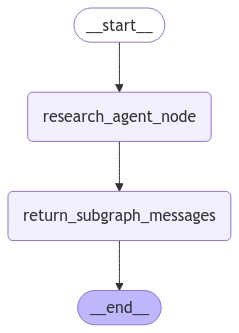

In [57]:
from IPython.display import Image
Image(subgraph.get_graph().draw_mermaid_png())

In [58]:
# Call the subgraph
def invoke_subgraph(state: SubState):
    message = HumanMessage(content=f"Record ID: {state['ID']}, Database: {state['database']}")
    messages = subgraph.invoke({"messages" : [message]})
    return {"messages" : messages}

invoke_subgraph({"ID" : "36004814", "database" : "sra"})

{'messages': {'messages': [HumanMessage(content='Record ID: 36004814, Database: sra', additional_kwargs={}, response_metadata={}, id='f6399fec-6c2f-4b8d-a2b5-2de769de9753'),
   HumanMessage(content='Record ID: 36004814, Database: sra', additional_kwargs={}, response_metadata={}, id='f6399fec-6c2f-4b8d-a2b5-2de769de9753'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_WGVOfvdL4LsWsmFdUziKlnRG', 'function': {'arguments': '{"database":"sra","dataset_id":"36004814"}', 'name': 'efetch'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 127, 'total_tokens': 150, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-

## Graph

In [59]:
class TopState(TypedDict):
    """
    Shared state of the agents in the graph
    """
    database: str
    # esearch IDs
    IDs: Annotated[List[str], operator.add]
    # messages
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [60]:
def run_esearch(state: TopState):
    query = '("single cell RNA sequencing" OR "single cell RNA-seq")'
    IDs = esearch.invoke({"esearch_query" : query, "database" : state["database"]})
    return {"IDs" : IDs}

def invoke_subgraph(state: SubState):
    message = HumanMessage(content=f"Record ID: {state['ID']}, Database: {state['database']}")
    messages = subgraph.invoke({"messages" : [message]})
    return {"messages" : messages}

# Here we define the logic to map out over the generated subjects
def continue_to_subgraphs(state: TopState):
    return [Send("invoke_subgraph", {"ID": x, "database" : state["database"]}) for x in state["IDs"]]

In [61]:
#-- graph --#
workflow = StateGraph(TopState)

# nodes
workflow.add_node("esearch_node", run_esearch)
workflow.add_node("invoke_subgraph", invoke_subgraph)

# edges
workflow.add_edge(START, "esearch_node")
workflow.add_conditional_edges("esearch_node", continue_to_subgraphs, ["invoke_subgraph"])
workflow.add_edge("invoke_subgraph", END)

# compile the graph
graph = workflow.compile()

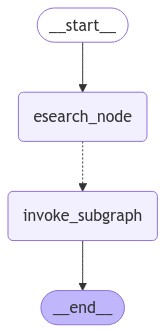

In [62]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [63]:
# Call the graph: here we call it to generate a list of jokes
for s in graph.stream({"database": "sra"}, subgraphs=True, config={"max_concurrency" : 2}):
    print(s)

((), {'esearch_node': {'IDs': ['36004814', '36004694']}})
(('invoke_subgraph:045a3f67-9d1e-938d-ee34-2293c7e5fcd4', 'research_agent_node:9e52fa1f-e31d-5f8c-6e90-af15f913edb0'), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zEwjTjuXDq0dXcNqA6RKphwt', 'function': {'arguments': '{"database":"sra","dataset_id":"36004814"}', 'name': 'efetch'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 127, 'total_tokens': 150, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0ba0d124f1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-9ba0e899-d42f-4cdb-87df-f7613690e2a5-0', tool_calls=[{'name': 'efetch', 'args': {'database': 'sra', 'dataset_id': '36004814'},

TypeError: unsupported operand type(s) for |: 'list' and 'AddableValuesDict'